In [1]:
year=2019
month=11

In [2]:
import pandas as pd
import sys
sys.path.append('../../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [3]:
conn=db.get_conn()
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000", con=conn)
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']




2019年11月全国招收程序员277672人。2019年11月全国程序员平均工资13451元，工资中位数12500元，其中95%的人的工资介于3750元到35000元。



In [4]:

join_counts=[conn.execute(f"select COUNT(1) from _{year}{month:02}").fetchall()[0][0]]
percents=[]
for i in range(1,month-6+1):
    sql=f"select COUNT(1) from _{year}{month:02} a join _{year}{month-i:02} b on a.job_id = b.job_id"
    #print(sql)
    count=conn.execute(sql).fetchall()[0][0]

    join_counts.append(count)
    subtract = join_counts[i-1]-join_counts[i]
    percents.append(subtract*1.0/join_counts[i])

percents.append(join_counts[-1]/join_counts[0])

In [5]:
join_counts

[89686, 75880, 64835, 55135, 46988, 42139]

In [6]:
percents

[0.1819451765946231,
 0.17035551785301148,
 0.17593180375442097,
 0.17338469396441644,
 0.11507154892142671,
 0.46985036683540354]

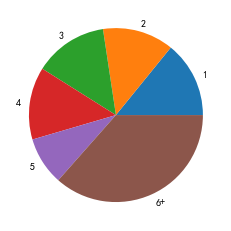

In [7]:
plt.pie(percents, labels=['1','2','3','4','5','6+'])
plt.show()

In [8]:
month

11

In [9]:
data.shape[0]

84685

In [10]:
conn.close()

In [11]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

data_format={"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}"}



In [12]:
data_career=get_sub_stats_by_col(data,'career')
data_career.style.format(data_format)

,career,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
2,系统架构师,22330,5250,20000,47500,8627,3.11%
1,算法工程师,18574,5000,16666,45000,24163,8.70%
0,一般程序员,12635,3750,12000,30000,244494,88.05%
3,爬虫工程师,12088,5250,11214,35000,353,0.13%
4,生物信息工程师,10714,7000,10000,15000,35,0.01%


# 程序员工资

In [13]:
data_city=get_sub_stats_by_col(data,'province')
#data_city.city=data_city.city.map(translate_dict)
data_city.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,17714,3750,15000,45000,24282,8.74%
上海,16390,5250,15000,37500,43913,15.81%
广东,14682,4500,12500,35000,72577,26.14%
浙江,13745,3500,12500,30000,17334,6.24%
四川,12114,3750,11500,29166,11851,4.27%
江苏,11878,3750,11500,25000,28798,10.37%
湖北,11539,3750,10500,25000,15083,5.43%
湖南,11126,3750,10500,25000,6066,2.18%
陕西,11069,3750,10500,23476,6763,2.44%
辽宁,10689,3000,9000,30000,12612,4.54%


In [14]:
def describe(data_city, career):
    
    for index, row in data_city.iterrows():
        print(f"2019年{month}月{row[0]}招收{career}{row[5]}人。2019年{month}月{row[0]}{career}平均工资{row[1]:.0f}元，工资中位数{row[3]:.0f}元，其中95%的人的工资介于{row[2]:.0f}元到{row[4]:.0f}元。\r\n")


In [15]:
describe(data_city,'程序员')

2019年11月北京招收程序员24282人。2019年11月北京程序员平均工资17714元，工资中位数15000元，其中95%的人的工资介于3750元到45000元。

2019年11月上海招收程序员43913人。2019年11月上海程序员平均工资16390元，工资中位数15000元，其中95%的人的工资介于5250元到37500元。

2019年11月广东招收程序员72577人。2019年11月广东程序员平均工资14682元，工资中位数12500元，其中95%的人的工资介于4500元到35000元。

2019年11月浙江招收程序员17334人。2019年11月浙江程序员平均工资13745元，工资中位数12500元，其中95%的人的工资介于3500元到30000元。

2019年11月四川招收程序员11851人。2019年11月四川程序员平均工资12114元，工资中位数11500元，其中95%的人的工资介于3750元到29166元。

2019年11月江苏招收程序员28798人。2019年11月江苏程序员平均工资11878元，工资中位数11500元，其中95%的人的工资介于3750元到25000元。

2019年11月湖北招收程序员15083人。2019年11月湖北程序员平均工资11539元，工资中位数10500元，其中95%的人的工资介于3750元到25000元。

2019年11月湖南招收程序员6066人。2019年11月湖南程序员平均工资11126元，工资中位数10500元，其中95%的人的工资介于3750元到25000元。

2019年11月陕西招收程序员6763人。2019年11月陕西程序员平均工资11069元，工资中位数10500元，其中95%的人的工资介于3750元到23476元。

2019年11月辽宁招收程序员12612人。2019年11月辽宁程序员平均工资10689元，工资中位数9000元，其中95%的人的工资介于3000元到30000元。

2019年11月重庆招收程序员4050人。2019年11月重庆程序员平均工资10468元，工资中位数10000元，其中95%的人的工资介于4000元到23819元。

2019年11月福建招收程序员5117人。2019年11月福建程序员平均工资10395元，工资中位数10000元，其中95%的人的工资介于

In [20]:
data_location = pd.read_csv('../geo_data/provincial_capital_locations.csv', encoding='utf-8')
data_location=data_location.set_index('province')

In [21]:
from mpl_toolkits.basemap import Basemap

In [22]:
def draw_map(data_city,headcount_scale, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='china', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city.salary_mean.min()
    salary_max=data_city.salary_mean.max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        province=row[0]
        
        longitude = data_location.loc[province,'longitude']
        latitude = data_location.loc[province,'latitude']
        salary=row[1]
        headcount=row[5]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/headcount_scale))+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(math.sqrt(headcount/headcount_scale))+13
        if province == '浙江':
            #x=x-400000
            y=y-100000

        elif province=='安徽':
            x=x-300000
            y=y+10000
        elif province=='江苏':
            x=x-150000
        elif province=='天津':
            y=y-50000
        elif province=='上海':
            x=x+50000
        elif province=='湖北':
            y=y-50000

        ax.text(x, y, "{}{:.0f}k".format(province, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(2053805, 1077845, "https://github.com/juwikuang/china_job_survey".format(province, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(province, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(province, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表招聘数量，颜色代表工资，红色最高，黄色次之，蓝最少）", fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()


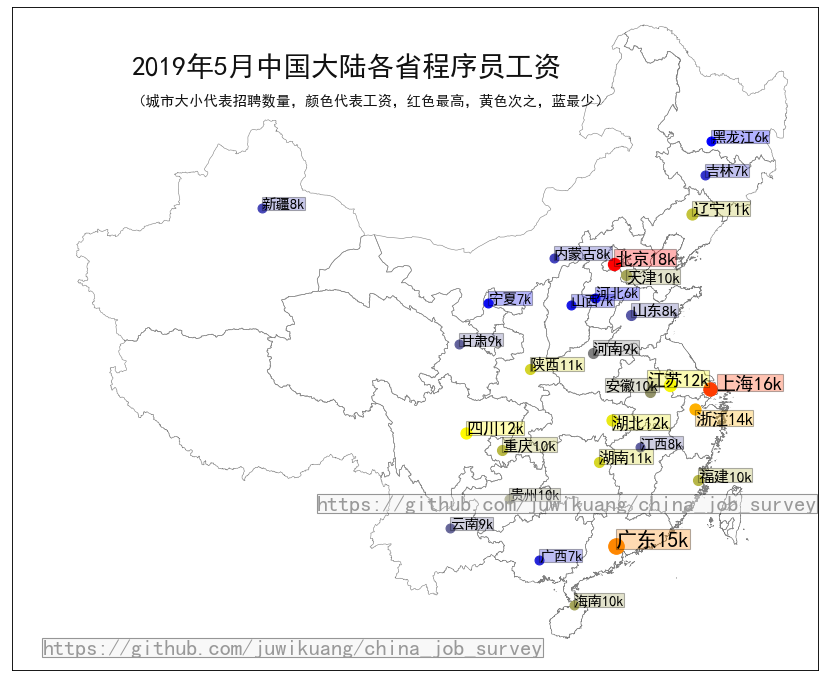

In [23]:
draw_map(data_city,2000,'2019年5月中国大陆各省程序员工资')

# 算法工程师

In [24]:
get_summary(data[data.career=='算法工程师'], '算法工程师')

2019年11月全国招收算法工程师24163人。2019年11月全国算法工程师平均工资18573元，工资中位数16666元，其中95%的人的工资介于5000元到45000元。



(24163, 18573, 16666.0)

In [25]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'province')

data_city_algorithm.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,23085,5250,20000,58333,3049,12.62%
上海,22109,7000,20000,45833,4665,19.31%
广东,19066,5000,17500,45000,6655,27.54%
海南,18864,12500,15000,35000,33,0.14%
浙江,18294,3868,16638,45000,1702,7.04%
江苏,16293,5000,15000,32868,2727,11.29%
湖北,15218,3865,15000,27500,1192,4.93%
四川,15061,5325,13917,33719,1061,4.39%
湖南,14269,5700,12500,27750,456,1.89%
陕西,13916,5348,12916,34516,651,2.69%


In [26]:
describe(data_city_algorithm,'算法工程师')

2019年11月北京招收算法工程师3049人。2019年11月北京算法工程师平均工资23085元，工资中位数20000元，其中95%的人的工资介于5250元到58333元。

2019年11月上海招收算法工程师4665人。2019年11月上海算法工程师平均工资22109元，工资中位数20000元，其中95%的人的工资介于7000元到45833元。

2019年11月广东招收算法工程师6655人。2019年11月广东算法工程师平均工资19066元，工资中位数17500元，其中95%的人的工资介于5000元到45000元。

2019年11月海南招收算法工程师33人。2019年11月海南算法工程师平均工资18864元，工资中位数15000元，其中95%的人的工资介于12500元到35000元。

2019年11月浙江招收算法工程师1702人。2019年11月浙江算法工程师平均工资18294元，工资中位数16638元，其中95%的人的工资介于3868元到45000元。

2019年11月江苏招收算法工程师2727人。2019年11月江苏算法工程师平均工资16293元，工资中位数15000元，其中95%的人的工资介于5000元到32868元。

2019年11月湖北招收算法工程师1192人。2019年11月湖北算法工程师平均工资15218元，工资中位数15000元，其中95%的人的工资介于3865元到27500元。

2019年11月四川招收算法工程师1061人。2019年11月四川算法工程师平均工资15061元，工资中位数13917元，其中95%的人的工资介于5325元到33719元。

2019年11月湖南招收算法工程师456人。2019年11月湖南算法工程师平均工资14269元，工资中位数12500元，其中95%的人的工资介于5700元到27750元。

2019年11月陕西招收算法工程师651人。2019年11月陕西算法工程师平均工资13916元，工资中位数12916元，其中95%的人的工资介于5348元到34516元。

2019年11月安徽招收算法工程师288人。2019年11月安徽算法工程师平均工资13711元，工资中位数12500元，其中95%的人的工资介于5350元到28250元。

2019年11月福建招收算法工程师232人。2019年11月福建算法工程

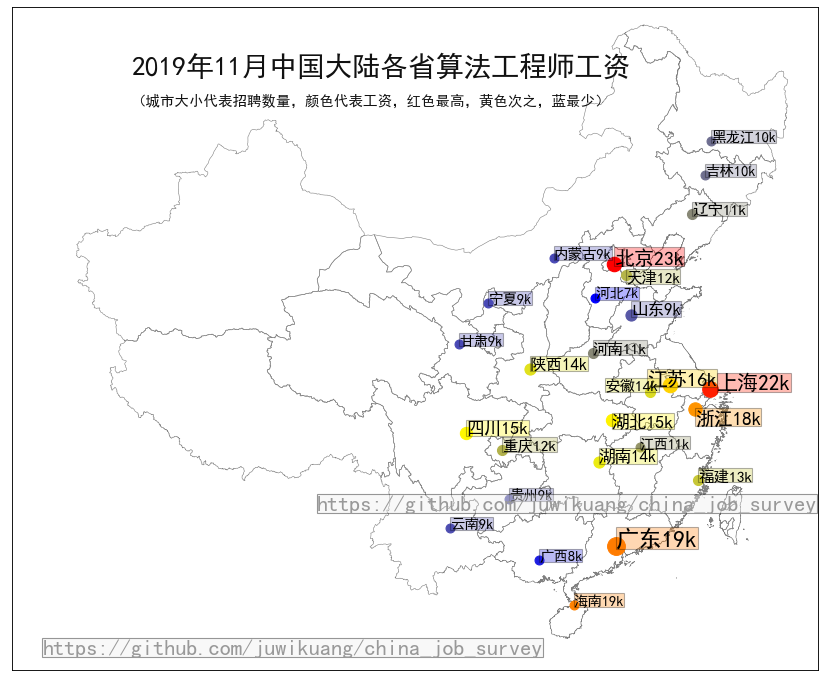

In [27]:
draw_map(data_city_algorithm,100,f'2019年{month}月中国大陆各省算法工程师工资')

# 系统架构师

In [28]:
get_summary(data[data.career=='系统架构师'], '系统架构师')

2019年11月全国招收系统架构师8627人。2019年11月全国系统架构师平均工资22329元，工资中位数20000元，其中95%的人的工资介于5250元到47500元。



(8627, 22329, 20000.0)

In [29]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'province')

data_city_architect.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
河北,38100,12500,29250,75000,5,0.06%
北京,31840,9000,32500,60000,1116,12.94%
浙江,23490,6535,24000,45000,537,6.22%
广东,23016,5250,22500,46241,2566,29.74%
上海,22989,7000,22500,50000,1867,21.64%
海南,22500,22500,22500,22500,5,0.06%
四川,19513,6948,19000,38812,319,3.70%
河南,18167,6500,18750,30000,12,0.14%
江苏,17614,5810,17500,37465,782,9.06%
湖北,17333,5725,17500,30687,398,4.61%


In [30]:
describe(data_city_architect,'系统架构师')

2019年11月河北招收系统架构师5人。2019年11月河北系统架构师平均工资38100元，工资中位数29250元，其中95%的人的工资介于12500元到75000元。

2019年11月北京招收系统架构师1116人。2019年11月北京系统架构师平均工资31840元，工资中位数32500元，其中95%的人的工资介于9000元到60000元。

2019年11月浙江招收系统架构师537人。2019年11月浙江系统架构师平均工资23490元，工资中位数24000元，其中95%的人的工资介于6535元到45000元。

2019年11月广东招收系统架构师2566人。2019年11月广东系统架构师平均工资23016元，工资中位数22500元，其中95%的人的工资介于5250元到46241元。

2019年11月上海招收系统架构师1867人。2019年11月上海系统架构师平均工资22989元，工资中位数22500元，其中95%的人的工资介于7000元到50000元。

2019年11月海南招收系统架构师5人。2019年11月海南系统架构师平均工资22500元，工资中位数22500元，其中95%的人的工资介于22500元到22500元。

2019年11月四川招收系统架构师319人。2019年11月四川系统架构师平均工资19513元，工资中位数19000元，其中95%的人的工资介于6948元到38812元。

2019年11月河南招收系统架构师12人。2019年11月河南系统架构师平均工资18167元，工资中位数18750元，其中95%的人的工资介于6500元到30000元。

2019年11月江苏招收系统架构师782人。2019年11月江苏系统架构师平均工资17614元，工资中位数17500元，其中95%的人的工资介于5810元到37465元。

2019年11月湖北招收系统架构师398人。2019年11月湖北系统架构师平均工资17333元，工资中位数17500元，其中95%的人的工资介于5725元到30687元。

2019年11月陕西招收系统架构师199人。2019年11月陕西系统架构师平均工资17085元，工资中位数17500元，其中95%的人的工资介于1750元到33762元。

2019年11月湖南招收系统架构师119人。2019年11月湖南系统架构师平均工资16

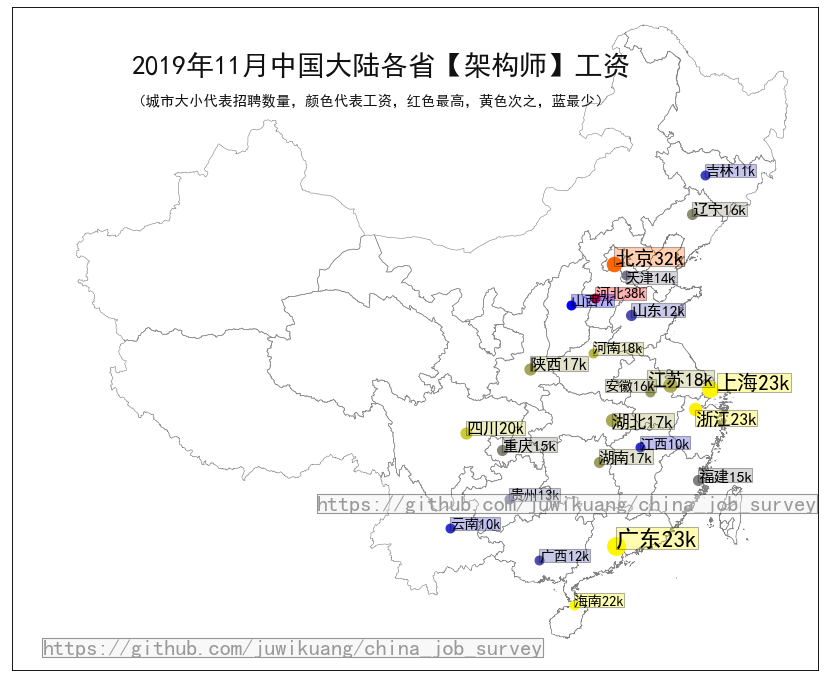

In [31]:
draw_map(data_city_architect,40,f'2019年{month}月中国大陆各省【架构师】工资')

# 生物信息工程师

In [32]:
get_summary(data[data.career=='生物信息工程师'], '生物信息工程师')

2019年11月全国招收生物信息工程师35人。2019年11月全国生物信息工程师平均工资10714元，工资中位数10000元，其中95%的人的工资介于7000元到15000元。



(35, 10714, 10000.0)

In [33]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'province')
#data_bio.city=data_bio.city.map(translate_dict)
data_bio.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,15000,15000,15000,15000,5,14.29%
吉林,11500,11500,11500,11500,2,5.71%
广东,10567,7000,10100,15000,15,42.86%
江苏,9875,9000,9875,12500,4,11.43%
上海,9800,8000,9800,12500,5,14.29%
湖北,9000,9000,9000,9000,1,2.86%
广西,7000,7000,7000,7000,3,8.57%


In [34]:
describe(data_bio,'生物信息工程师')

2019年11月北京招收生物信息工程师5人。2019年11月北京生物信息工程师平均工资15000元，工资中位数15000元，其中95%的人的工资介于15000元到15000元。

2019年11月吉林招收生物信息工程师2人。2019年11月吉林生物信息工程师平均工资11500元，工资中位数11500元，其中95%的人的工资介于11500元到11500元。

2019年11月广东招收生物信息工程师15人。2019年11月广东生物信息工程师平均工资10567元，工资中位数10100元，其中95%的人的工资介于7000元到15000元。

2019年11月江苏招收生物信息工程师4人。2019年11月江苏生物信息工程师平均工资9875元，工资中位数9875元，其中95%的人的工资介于9000元到12500元。

2019年11月上海招收生物信息工程师5人。2019年11月上海生物信息工程师平均工资9800元，工资中位数9800元，其中95%的人的工资介于8000元到12500元。

2019年11月湖北招收生物信息工程师1人。2019年11月湖北生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年11月广西招收生物信息工程师3人。2019年11月广西生物信息工程师平均工资7000元，工资中位数7000元，其中95%的人的工资介于7000元到7000元。



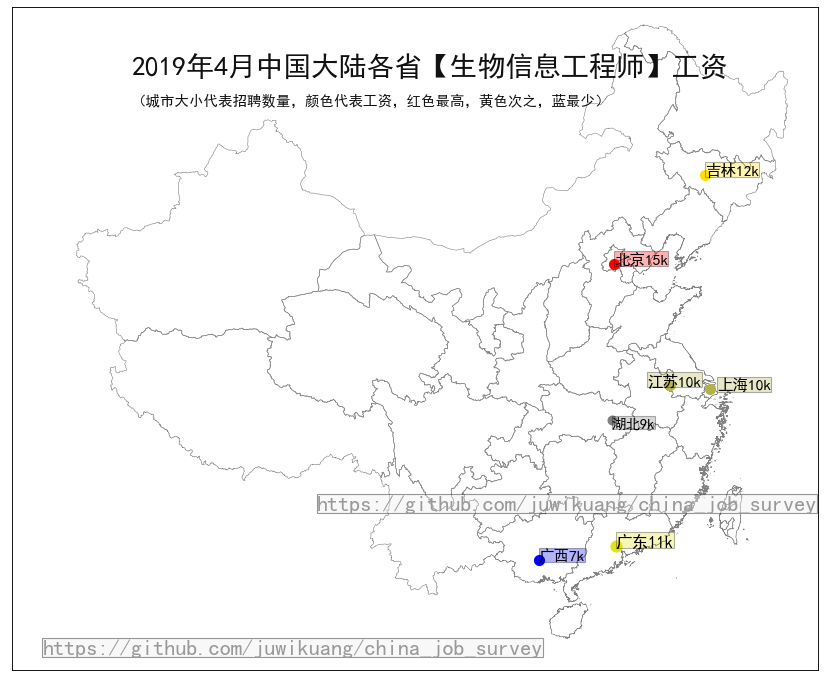

In [35]:
draw_map(data_bio,2,'2019年4月中国大陆各省【生物信息工程师】工资')

# 爬虫工程师

In [36]:
get_summary(data[data.career=='爬虫工程师'], '爬虫工程师')

2019年11月全国招收爬虫工程师353人。2019年11月全国爬虫工程师平均工资12087元，工资中位数11214元，其中95%的人的工资介于5250元到35000元。



(353, 12087, 11214.285714285716)

In [37]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'province')


data_spider=data_spider[data_spider.head_count>10]
data_spider.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,17393,1750,12500,35000,28,7.93%
江苏,15133,11500,12500,20000,15,4.25%
上海,13532,4791,12500,28375,93,26.35%
广东,12952,5250,11100,37500,93,26.35%
湖北,12136,7000,12000,20000,11,3.12%
浙江,11214,9000,11500,12500,14,3.97%
湖南,9273,7000,9000,12483,22,6.23%
安徽,7000,7000,7000,7000,17,4.82%
四川,6941,6000,6250,15750,34,9.63%
陕西,6083,5250,6250,6250,12,3.40%


In [38]:
describe(data_spider, '爬虫工程师')

2019年11月北京招收爬虫工程师28人。2019年11月北京爬虫工程师平均工资17393元，工资中位数12500元，其中95%的人的工资介于1750元到35000元。

2019年11月江苏招收爬虫工程师15人。2019年11月江苏爬虫工程师平均工资15133元，工资中位数12500元，其中95%的人的工资介于11500元到20000元。

2019年11月上海招收爬虫工程师93人。2019年11月上海爬虫工程师平均工资13532元，工资中位数12500元，其中95%的人的工资介于4791元到28375元。

2019年11月广东招收爬虫工程师93人。2019年11月广东爬虫工程师平均工资12952元，工资中位数11100元，其中95%的人的工资介于5250元到37500元。

2019年11月湖北招收爬虫工程师11人。2019年11月湖北爬虫工程师平均工资12136元，工资中位数12000元，其中95%的人的工资介于7000元到20000元。

2019年11月浙江招收爬虫工程师14人。2019年11月浙江爬虫工程师平均工资11214元，工资中位数11500元，其中95%的人的工资介于9000元到12500元。

2019年11月湖南招收爬虫工程师22人。2019年11月湖南爬虫工程师平均工资9273元，工资中位数9000元，其中95%的人的工资介于7000元到12483元。

2019年11月安徽招收爬虫工程师17人。2019年11月安徽爬虫工程师平均工资7000元，工资中位数7000元，其中95%的人的工资介于7000元到7000元。

2019年11月四川招收爬虫工程师34人。2019年11月四川爬虫工程师平均工资6941元，工资中位数6250元，其中95%的人的工资介于6000元到15750元。

2019年11月陕西招收爬虫工程师12人。2019年11月陕西爬虫工程师平均工资6083元，工资中位数6250元，其中95%的人的工资介于5250元到6250元。



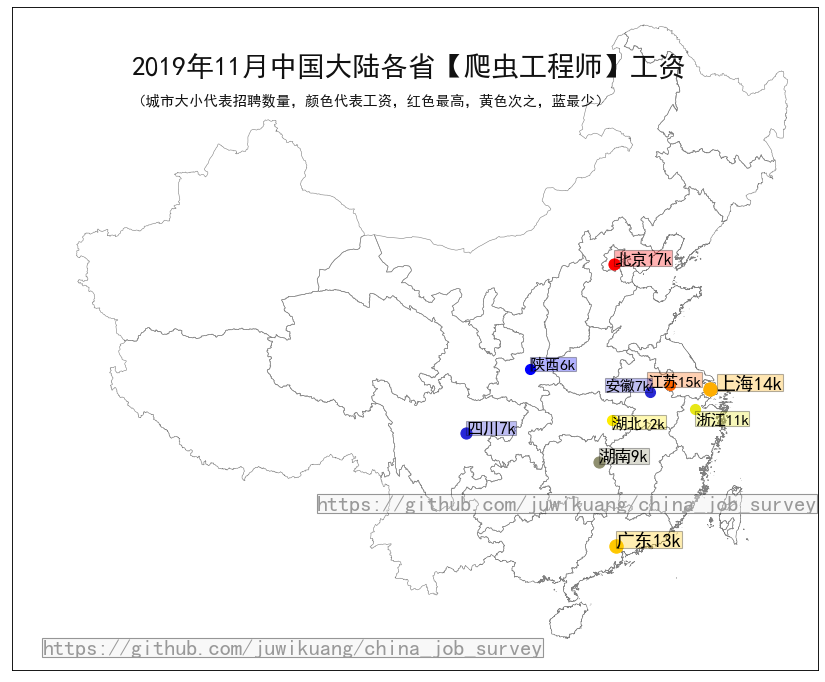

In [39]:
draw_map(data_spider,5,f'2019年{month}月中国大陆各省【爬虫工程师】工资')

# Java程序员

In [40]:
get_summary(data[data.pl_java==1], 'Java程序员')

2019年11月全国招收Java程序员126905人。2019年11月全国Java程序员平均工资13340元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。



(126905, 13340, 12500.0)

In [41]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'province')
data_java.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,16644,3750,14500,37500,11616,9.15%
上海,16543,5500,15000,35000,19133,15.08%
广东,14672,4549,12500,32500,32657,25.73%
浙江,13934,3500,12500,30000,8187,6.45%
江苏,11734,3750,11000,25000,13213,10.41%
四川,11611,3500,11000,25000,4975,3.92%
湖北,11307,4500,10500,25000,5900,4.65%
辽宁,11187,2500,9000,30000,6941,5.47%
陕西,10990,3000,10500,22500,3048,2.40%
湖南,10756,3750,10500,20833,2728,2.15%


In [42]:
describe(data_java, 'Java程序员')

2019年11月北京招收Java程序员11616人。2019年11月北京Java程序员平均工资16644元，工资中位数14500元，其中95%的人的工资介于3750元到37500元。

2019年11月上海招收Java程序员19133人。2019年11月上海Java程序员平均工资16543元，工资中位数15000元，其中95%的人的工资介于5500元到35000元。

2019年11月广东招收Java程序员32657人。2019年11月广东Java程序员平均工资14672元，工资中位数12500元，其中95%的人的工资介于4549元到32500元。

2019年11月浙江招收Java程序员8187人。2019年11月浙江Java程序员平均工资13934元，工资中位数12500元，其中95%的人的工资介于3500元到30000元。

2019年11月江苏招收Java程序员13213人。2019年11月江苏Java程序员平均工资11734元，工资中位数11000元，其中95%的人的工资介于3750元到25000元。

2019年11月四川招收Java程序员4975人。2019年11月四川Java程序员平均工资11611元，工资中位数11000元，其中95%的人的工资介于3500元到25000元。

2019年11月湖北招收Java程序员5900人。2019年11月湖北Java程序员平均工资11307元，工资中位数10500元，其中95%的人的工资介于4500元到25000元。

2019年11月辽宁招收Java程序员6941人。2019年11月辽宁Java程序员平均工资11187元，工资中位数9000元，其中95%的人的工资介于2500元到30000元。

2019年11月陕西招收Java程序员3048人。2019年11月陕西Java程序员平均工资10990元，工资中位数10500元，其中95%的人的工资介于3000元到22500元。

2019年11月湖南招收Java程序员2728人。2019年11月湖南Java程序员平均工资10756元，工资中位数10500元，其中95%的人的工资介于3750元到20833元。

2019年11月重庆招收Java程序员1898人。2019年11月重庆Java程序员平均工资10317元，工资中位数10000元，其中95%的人的工资介于

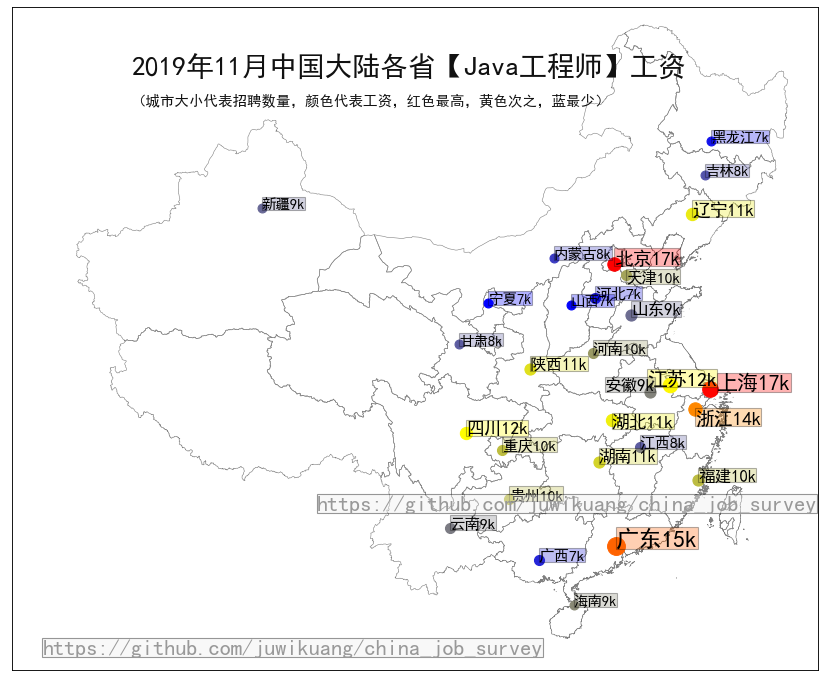

In [43]:
draw_map(data_java, 500, f'2019年{month}月中国大陆各省【Java工程师】工资')

# Python程序员

In [44]:
get_summary(data[data.pl_python==1], 'Python程序员')

2019年11月全国招收Python程序员29916人。2019年11月全国Python程序员平均工资17490元，工资中位数15000元，其中95%的人的工资介于3750元到41666元。



(29916, 17490, 15000.0)

In [45]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'province')
data_python.style.hide_index().format(data_format)

province,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,23253,3941,21500,58333,4141,13.84%
上海,20785,6500,19000,45000,5948,19.88%
广东,18163,4500,16500,40000,7394,24.72%
海南,16851,6500,15000,35000,47,0.16%
浙江,16124,3750,15000,37500,1916,6.40%
四川,15162,3750,13500,32000,1552,5.19%
江苏,14299,4897,12500,31250,3016,10.08%
湖北,14192,5082,12500,29649,1379,4.61%
重庆,13617,4124,12500,32675,333,1.11%
湖南,12952,3854,12500,32479,561,1.88%


In [46]:
describe(data_python, 'Python程序员')

2019年11月北京招收Python程序员4141人。2019年11月北京Python程序员平均工资23253元，工资中位数21500元，其中95%的人的工资介于3941元到58333元。

2019年11月上海招收Python程序员5948人。2019年11月上海Python程序员平均工资20785元，工资中位数19000元，其中95%的人的工资介于6500元到45000元。

2019年11月广东招收Python程序员7394人。2019年11月广东Python程序员平均工资18163元，工资中位数16500元，其中95%的人的工资介于4500元到40000元。

2019年11月海南招收Python程序员47人。2019年11月海南Python程序员平均工资16851元，工资中位数15000元，其中95%的人的工资介于6500元到35000元。

2019年11月浙江招收Python程序员1916人。2019年11月浙江Python程序员平均工资16124元，工资中位数15000元，其中95%的人的工资介于3750元到37500元。

2019年11月四川招收Python程序员1552人。2019年11月四川Python程序员平均工资15162元，工资中位数13500元，其中95%的人的工资介于3750元到32000元。

2019年11月江苏招收Python程序员3016人。2019年11月江苏Python程序员平均工资14299元，工资中位数12500元，其中95%的人的工资介于4897元到31250元。

2019年11月湖北招收Python程序员1379人。2019年11月湖北Python程序员平均工资14192元，工资中位数12500元，其中95%的人的工资介于5082元到29649元。

2019年11月重庆招收Python程序员333人。2019年11月重庆Python程序员平均工资13617元，工资中位数12500元，其中95%的人的工资介于4124元到32675元。

2019年11月湖南招收Python程序员561人。2019年11月湖南Python程序员平均工资12952元，工资中位数12500元，其中95%的人的工资介于3854元到32479元。

2019年11月陕西招收Python程序员725人。2019年11月陕西Python程序

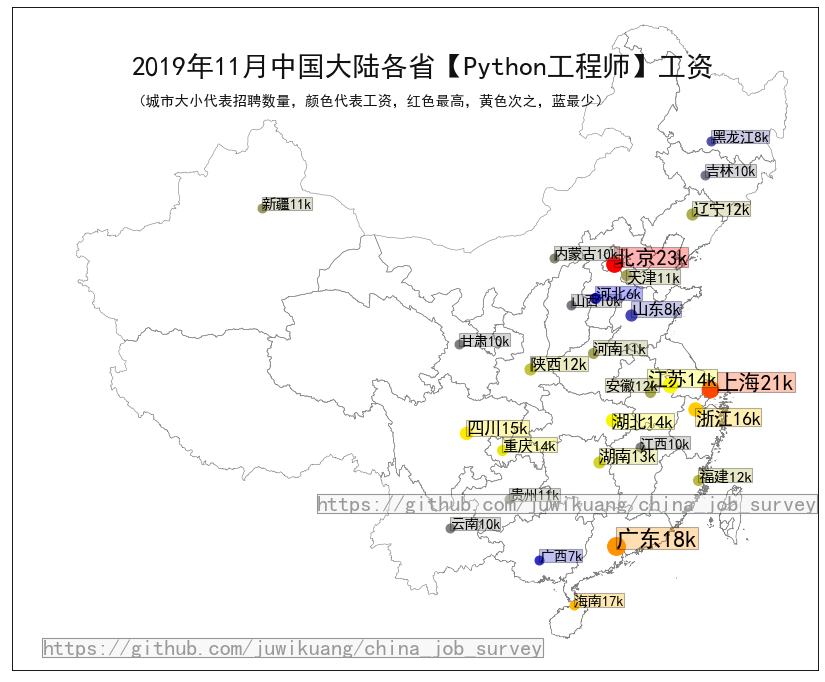

In [47]:
draw_map(data_python, 100,  f'2019年{month}月中国大陆各省【Python工程师】工资')